# Deep Learning for z_photo prediction

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import requests
import pandas as pd
import numpy as np
import os
import time
import warnings
import matplotlib.pyplot as plt
from PIL import Image
import io

path = '/content/drive/MyDrive/John/Work/Tec/02_Research/MACSS/2025/data'

In [3]:
import re

def extract_coordinates(desi_name):
    """
    Extract RA and Dec coordinates from DESI object name.

    Parameters:
    -----------
    desi_name : str
        DESI object name in format 'DESI JHHH.MMMM±DD.MMMM'
        Examples:
        - 'DESI J036.7545+22.2632' -> RA=36.7545, Dec=22.2632
        - 'DESI J201.3880-02.9397' -> RA=201.3880, Dec=-2.9397

    Returns:
    --------
    tuple : (ra, dec) as floats
    """
    pattern = r'DESI J(\d+\.\d+)([+-]\d+\.\d+)'
    match = re.match(pattern, desi_name)

    if match:
        ra = float(match.group(1))
        dec = float(match.group(2))
        return ra, dec
    else:
        raise ValueError(f"Could not extract coordinates from: {desi_name}")

In [4]:
# Read the CSV file with spectral types
df_spectra = pd.read_csv(f'{path}/balanced_spectra_features.csv')
print("CSV columns:", df_spectra.columns.tolist())

print(df_spectra.tail())

CSV columns: ['targetid', 'survey', 'program', 'desi_target', 'z', 'zwarn', 'spectype', 'desiname', 'specid', 'redshift']
              targetid survey program          desi_target         z  zwarn  \
487  39628031613995781   main    dark  4611686018427650052  1.132489      0   
488  39627689362983081   main    dark  4611686018428829830  0.870082      0   
489  39627474228742564   main    dark  4611686018428829830  1.057718      0   
490  39627812356756299   main    dark  4611686018427650052  1.293974      0   
491  39627869730643820   main    dark  6917529027641344004  0.777878      0   

    spectype                desiname        specid  redshift  
487   GALAXY  DESI J020.5016+10.2330  3.962803e+16  1.132489  
488   GALAXY  DESI J073.9506-03.9645  3.962769e+16  0.870082  
489   GALAXY  DESI J065.4778-12.9870  3.962747e+16  1.057718  
490      QSO  DESI J206.9822+01.0158  3.962781e+16  1.293974  
491      QSO  DESI J027.2577+03.5412  3.962787e+16  0.777878  


In [5]:
# Extract coordinates for all objects in df_spectra
coordinates = []
for desi_name in df_spectra['desiname']:
    try:
        ra, dec = extract_coordinates(desi_name)
        coordinates.append((ra, dec))
    except ValueError:
        coordinates.append((None, None))
        print(f"Warning: Could not extract coordinates from: {desi_name}")

# Add coordinates to DataFrame
df_spectra['ra'] = [coord[0] for coord in coordinates]
df_spectra['dec'] = [coord[1] for coord in coordinates]

print(f"Successfully extracted coordinates for {df_spectra['ra'].notna().sum()} out of {len(df_spectra)} objects")

Successfully extracted coordinates for 492 out of 492 objects


In [6]:
df_spectra.head()

,targetid,survey,program,desi_target,z,zwarn,spectype,desiname,specid,redshift,ra,dec
0,39627676645858382,main,bright,1152921504606846976,0.151948,0,GALAXY,DESI J034.5482-04.5184,3.962768e+16,0.151948,34.5482,-4.5184
1,39633503586878645,main,bright,1152921504606846976,0.229641,0,GALAXY,DESI J171.5833+71.6438,3.963350e+16,0.229641,171.5833,71.6438
2,39627497528105417,main,bright,1152921504606846976,0.083919,0,GALAXY,DESI J047.1781-12.1055,3.962750e+16,0.083919,47.1781,-12.1055
3,39627958884767055,main,bright,1152921504606846976,0.093509,0,GALAXY,DESI J319.8957+06.9128,3.962796e+16,0.093509,319.8957,6.9128
4,39627683142828674,main,bright,1152921504606846976,0.072260,0,GALAXY,DESI J062.6146-04.2960,3.962768e+16,0.072260,62.6146,-4.2960


In [7]:
# def download_legacy_cutout(ra, dec, size=64, pixscale=0.5, layer='ls-dr9'):
#     """
#     Download cutout image from Legacy Survey API
#     """
#     url = f"https://www.legacysurvey.org/viewer/cutout.jpg"
#     params = {
#         'ra': ra,
#         'dec': dec,
#         'size': size,
#         'pixscale': pixscale,
#         'layer': layer
#     }

#     try:
#         response = requests.get(url, params=params, timeout=30)
#         response.raise_for_status()

#         image = Image.open(io.BytesIO(response.content))
#         image_array = np.array(image)

#         return image_array

#     except Exception as e:
#         print(f"Error downloading cutout for RA={ra}, Dec={dec}: {e}")
#         return None

# def download_all_cutouts_incremental(df_spectra, output_file='legacy_cutouts.npz', path='', max_images=None):
#     """
#     Download Legacy Survey cutouts incrementally, saving each image as it's downloaded
#     """
#     # Create output directory if it doesn't exist
#     os.makedirs(f'{path}/cutouts_individual', exist_ok=True)

#     # Load already downloaded targetids
#     downloaded_targetids = set()
#     if os.path.exists(f'{path}/downloaded_targetids.txt'):
#         with open(f'{path}/downloaded_targetids.txt', 'r') as f:
#             downloaded_targetids = set(line.strip() for line in f)
#         print(f"Found {len(downloaded_targetids)} previously downloaded images")

#     images = {}
#     failed_downloads = 0
#     new_downloads = 0

#     total = len(df_spectra) if max_images is None else min(max_images, len(df_spectra))

#     print(f"Processing {total} objects...")

#     for idx, row in df_spectra.iterrows():
#         if max_images is not None and (new_downloads + len(downloaded_targetids)) >= max_images:
#             break

#         targetid = str(row['targetid'])
#         ra = row['ra']
#         dec = row['dec']

#         # Skip if coordinates are missing
#         if pd.isna(ra) or pd.isna(dec):
#             print(f"Skipping {targetid}: missing coordinates")
#             failed_downloads += 1
#             continue

#         # Check if already downloaded
#         individual_file = f'{path}/cutouts_individual/{targetid}.npy'
#         if targetid in downloaded_targetids and os.path.exists(individual_file):
#             try:
#                 # Load previously downloaded image
#                 image_array = np.load(individual_file)
#                 images[targetid] = image_array
#                 print(f"Loaded existing: {idx+1}/{total} - TargetID: {targetid}")
#                 continue
#             except:
#                 # If loading fails, re-download
#                 print(f"Failed to load existing file for {targetid}, re-downloading...")

#         # Download new image
#         print(f"Downloading {idx+1}/{total}: TargetID: {targetid}, RA={ra:.4f}, Dec={dec:.4f}")

#         image_array = download_legacy_cutout(ra, dec, size=64, pixscale=0.5)

#         if image_array is not None:
#             # Save individual image
#             np.save(individual_file, image_array)

#             # Add to images dictionary
#             images[targetid] = image_array

#             # Add to downloaded list
#             downloaded_targetids.add(targetid)
#             new_downloads += 1

#             # Update downloaded targetids file
#             with open(f'{path}/downloaded_targetids.txt', 'w') as f:
#                 for tid in downloaded_targetids:
#                     f.write(f"{tid}\n")
#         else:
#             failed_downloads += 1

#         # Add small delay to be respectful to the API
#         time.sleep(0.1)

#     # Save combined NPZ file
#     if images:
#         np.savez(path+output_file, **images)
#         print(f"Saved combined file: {path}/{output_file}")

#     print(f"\nDownload completed!")
#     print(f"Total images available: {len(images)}")
#     print(f"New downloads: {new_downloads}")
#     print(f"Failed downloads: {failed_downloads}")

#     return images

# def load_all_cutouts():
#     """
#     Load all previously downloaded cutouts
#     """
#     images = {}

#     if not os.path.exists(f'{path}downloaded_targetids.txt'):
#         print("No downloaded images found")
#         return images

#     # Load targetids
#     with open(f'{path}downloaded_targetids.txt', 'r') as f:
#         targetids = [line.strip() for line in f]

#     print(f"Loading {len(targetids)} images...")

#     for targetid in targetids:
#         individual_file = f'cutouts_individual/{targetid}.npy'
#         if os.path.exists(individual_file):
#             try:
#                 images[targetid] = np.load(individual_file)
#             except:
#                 print(f"Failed to load: {targetid}")

#     print(f"Successfully loaded {len(images)} images")
#     return images

# # Download new cutouts incrementally
# images_dict = download_all_cutouts_incremental(df_spectra, 'legacy_cutouts.npz' , path)

Loaded 492 cutout images
Image 1: TargetID 39627676645858382, Shape: (64, 64, 3), Range: [1, 255]
Image 2: TargetID 39633503586878645, Shape: (64, 64, 3), Range: [0, 192]
Image 3: TargetID 39627497528105417, Shape: (64, 64, 3), Range: [1, 219]
Image 4: TargetID 39627958884767055, Shape: (64, 64, 3), Range: [0, 255]
Image 5: TargetID 39627683142828674, Shape: (64, 64, 3), Range: [0, 255]


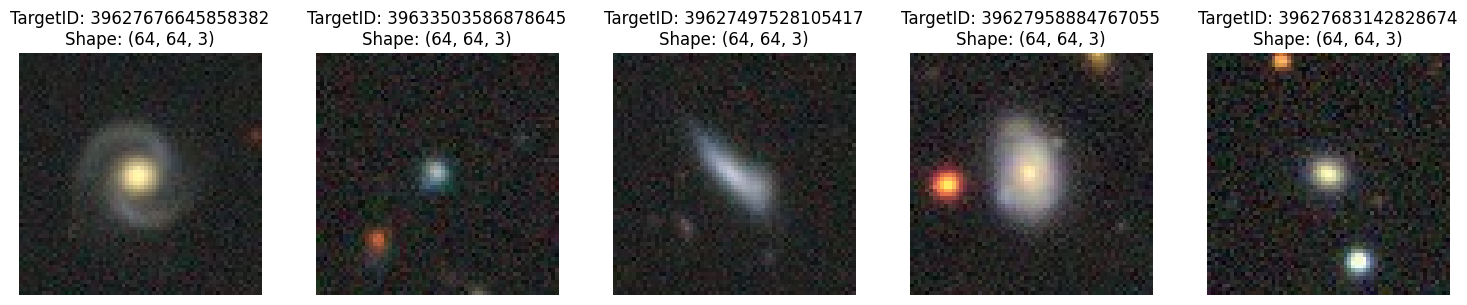

In [8]:
# Load the cutouts
cutouts_data = np.load(f'{path}/legacy_cutouts.npz')
targetids = list(cutouts_data.files)

print(f"Loaded {len(targetids)} cutout images")

# Plot a sample of the cutouts
n_samples = 5
fig, axes = plt.subplots(1, n_samples, figsize=(15, 3))

for i, targetid in enumerate(targetids[:n_samples]):
    image = cutouts_data[targetid]

    axes[i].imshow(image)
    axes[i].set_title(f'TargetID: {targetid}\nShape: {image.shape}')
    axes[i].axis('off')

    print(f"Image {i+1}: TargetID {targetid}, Shape: {image.shape}, Range: [{image.min()}, {image.max()}]")

plt.tight_layout()
plt.show()

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Define custom dataset
class CutoutDataset(Dataset):
    def __init__(self, images, redshifts, transform=None):
        self.images = images
        self.redshifts = redshifts
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        redshift = self.redshifts[idx]

        # Convert to tensor and normalize
        image_tensor = torch.FloatTensor(image) / 255.0
        # Change from HWC to CHW format
        image_tensor = image_tensor.permute(2, 0, 1)

        redshift_tensor = torch.FloatTensor([redshift])

        if self.transform:
            image_tensor = self.transform(image_tensor)

        return image_tensor, redshift_tensor

# Define CNN model
class RedshiftCNN(nn.Module):
    def __init__(self):
        super(RedshiftCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            # First conv block
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            # Second conv block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),

            # Third conv block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),

            # Fourth conv block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.AdaptiveAvgPool2d((4, 4))
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Prepare data
def prepare_dl_data(cutouts_data, df_spectra):
    """
    Prepare data for deep learning training
    """
    # Match cutouts with redshifts
    images = []
    redshifts = []
    targetids = []

    for targetid in cutouts_data.files:
        if targetid in df_spectra['targetid'].astype(str).values:
            # Find the row in df_spectra for this targetid
            row = df_spectra[df_spectra['targetid'].astype(str) == targetid].iloc[0]
            images.append(cutouts_data[targetid])
            redshifts.append(row['redshift'])
            targetids.append(targetid)

    images = np.array(images)
    redshifts = np.array(redshifts)

    print(f"Prepared {len(images)} images for training")
    print(f"Redshift range: {redshifts.min():.3f} to {redshifts.max():.3f}")
    print(f"Image shape: {images[0].shape}")

    return images, redshifts, targetids

In [10]:
# Load cutouts and prepare data
cutouts_data = np.load(f'{path}/legacy_cutouts.npz')
images, redshifts, targetids = prepare_dl_data(cutouts_data, df_spectra)

# Train-test split
X_train, X_test, y_train, y_test, train_targetids, test_targetids = train_test_split(images, redshifts, targetids, test_size=0.3, random_state=42)

print(f"Training set: {len(X_train)} images")
print(f"Test set: {len(X_test)} images")

# Create datasets and dataloaders
train_dataset = CutoutDataset(X_train, y_train)
test_dataset = CutoutDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Prepared 492 images for training
Redshift range: -0.001 to 3.457
Image shape: (64, 64, 3)
Training set: 344 images
Test set: 148 images


In [11]:
# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = RedshiftCNN().to(device)
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

Using device: cuda


In [12]:
# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs=50):
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0

        for images, redshifts in train_loader:
            images = images.to(device)
            redshifts = redshifts.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, redshifts)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        test_loss = 0.0

        with torch.no_grad():
            for images, redshifts in test_loader:
                images = images.to(device)
                redshifts = redshifts.to(device)

                outputs = model(images)
                loss = criterion(outputs, redshifts)
                test_loss += loss.item() * images.size(0)

        test_loss = test_loss / len(test_loader.dataset)
        test_losses.append(test_loss)

        scheduler.step(test_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    return train_losses, test_losses

# Train the model
print("Starting training...")
train_losses, test_losses = train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs=250)

Starting training...
Epoch [10/250], Train Loss: 0.1183, Test Loss: 0.3418
Epoch [20/250], Train Loss: 0.0827, Test Loss: 0.4050
Epoch [30/250], Train Loss: 0.0638, Test Loss: 0.2761
Epoch [40/250], Train Loss: 0.0345, Test Loss: 0.2792
Epoch [50/250], Train Loss: 0.0283, Test Loss: 0.2612
Epoch [60/250], Train Loss: 0.0234, Test Loss: 0.2593
Epoch [70/250], Train Loss: 0.0220, Test Loss: 0.2607
Epoch [80/250], Train Loss: 0.0244, Test Loss: 0.2580
Epoch [90/250], Train Loss: 0.0222, Test Loss: 0.2576
Epoch [100/250], Train Loss: 0.0233, Test Loss: 0.2595
Epoch [110/250], Train Loss: 0.0195, Test Loss: 0.2595
Epoch [120/250], Train Loss: 0.0220, Test Loss: 0.2621
Epoch [130/250], Train Loss: 0.0207, Test Loss: 0.2588
Epoch [140/250], Train Loss: 0.0229, Test Loss: 0.2602
Epoch [150/250], Train Loss: 0.0198, Test Loss: 0.2583
Epoch [160/250], Train Loss: 0.0219, Test Loss: 0.2587
Epoch [170/250], Train Loss: 0.0241, Test Loss: 0.2597
Epoch [180/250], Train Loss: 0.0215, Test Loss: 0.259

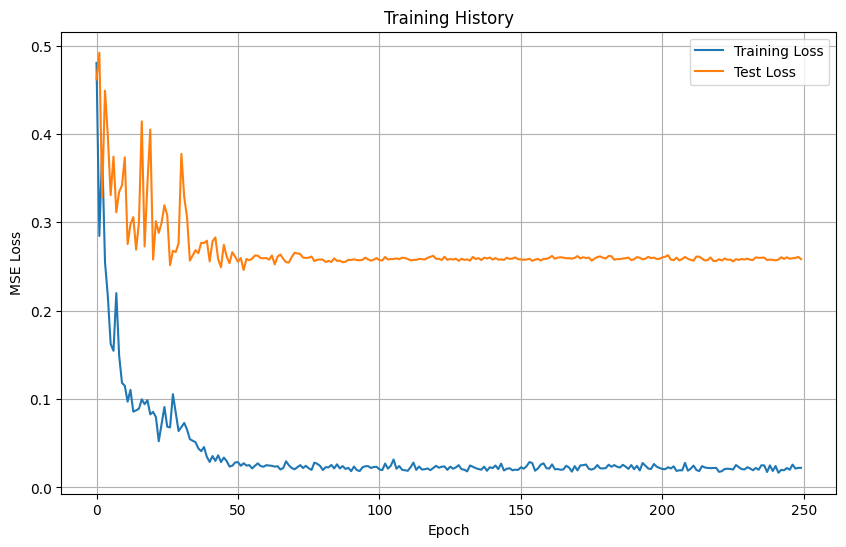


Model Performance:
MSE: 0.2584
MAE: 0.3003
R²: 0.4592


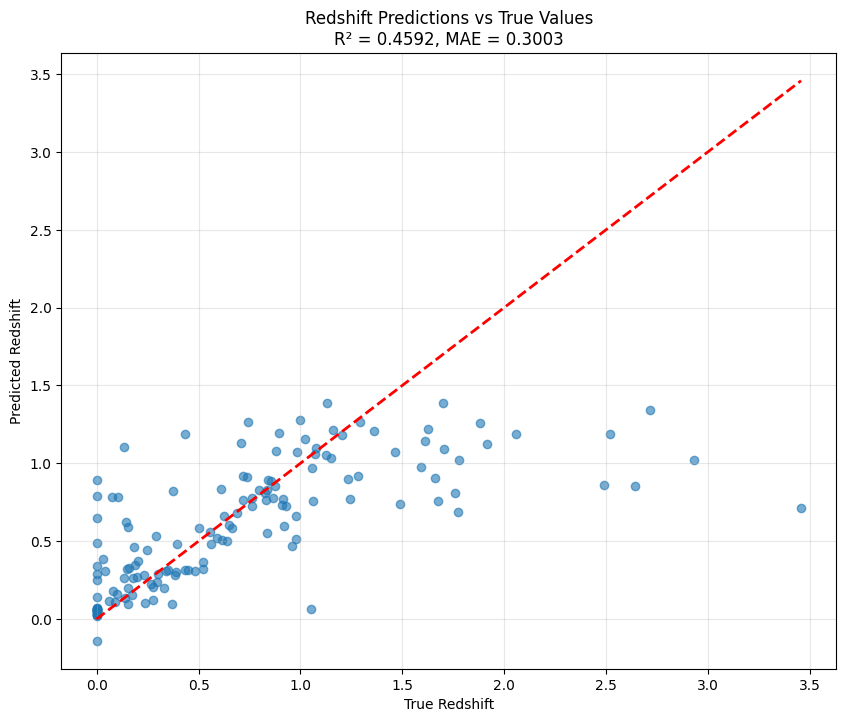

In [13]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    true_redshifts = []

    with torch.no_grad():
        for images, redshifts in test_loader:
            images = images.to(device)
            outputs = model(images)

            predictions.extend(outputs.cpu().numpy())
            true_redshifts.extend(redshifts.numpy())

    predictions = np.array(predictions).flatten()
    true_redshifts = np.array(true_redshifts).flatten()

    # Calculate metrics
    mse = np.mean((predictions - true_redshifts) ** 2)
    mae = np.mean(np.abs(predictions - true_redshifts))
    r2 = 1 - np.sum((true_redshifts - predictions) ** 2) / np.sum((true_redshifts - np.mean(true_redshifts)) ** 2)

    return predictions, true_redshifts, mse, mae, r2

# Make predictions
predictions, true_redshifts, mse, mae, r2 = evaluate_model(model, test_loader)

print(f"\nModel Performance:")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

# Plot predictions vs true values
plt.figure(figsize=(10, 8))
plt.scatter(true_redshifts, predictions, alpha=0.6)
plt.plot([true_redshifts.min(), true_redshifts.max()],
         [true_redshifts.min(), true_redshifts.max()], 'r--', linewidth=2)
plt.xlabel('True Redshift')
plt.ylabel('Predicted Redshift')
plt.title(f'Redshift Predictions vs True Values\nR² = {r2:.4f}, MAE = {mae:.4f}')
plt.grid(True, alpha=0.3)
plt.show()

In [14]:
# Save the model
torch.save(model.state_dict(), f'{path}/redshift_cnn_model.pth')
print("Model saved as 'redshift_cnn_model.pth'")

Model saved as 'redshift_cnn_model.pth'


# Workshop Activity: Improve the CNN Model

### Goal
Make the CNN model better at predicting redshifts from galaxy images.

### What to Do
1. Try Different CNN Designs
* Change the number of layers (try more or less)
* Test different filter sizes (3×3, 5×5)
* Adjust how many filters to use in each layer

2. Change Training Settings
* Try different learning rates (0.01, 0.001, 0.0001)
* Test different batch sizes (16, 32, 64)
* Use different optimizers (Adam, SGD)

3. Improve Training
* Add dropout to prevent overfitting
* Use learning rate scheduling
* Add image augmentation (rotate, flip images)

4. Check Results
* Look at MSE, MAE, and R² scores
* Plot predictions vs true values
* Find where the model makes big mistakes